In [1]:
import matplotlib.pyplot as plt
from tqdm import tqdm
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.utils.plotting import plot_series
from xgboost import XGBRegressor
import numpy as np

In [2]:
import pandas as pd

train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
submission = pd.read_csv('data/sample_submission.csv')
building = pd.read_csv('data/building_info.csv')

In [3]:
train = train.rename(columns={
    '건물번호': 'building_number',
    '일시': 'date_time',
    '기온(C)': 'temperature',
    '강수량(mm)': 'rainfall',
    '풍속(m/s)': 'windspeed',
    '습도(%)': 'humidity',
    '일조(hr)': 'sunshine',
    '일사(MJ/m2)': 'solar_radiation',
    '전력소비량(kWh)': 'power_consumption'
})
train.drop(['num_date_time','sunshine','solar_radiation'], axis = 1, inplace=True)

In [4]:
test = test.rename(columns={
    '건물번호': 'building_number',
    '일시': 'date_time',
    '기온(C)': 'temperature',
    '강수량(mm)': 'rainfall',
    '풍속(m/s)': 'windspeed',
    '습도(%)': 'humidity',
    '일조(hr)': 'sunshine',
    '일사(MJ/m2)': 'solar_radiation',
    '전력소비량(kWh)': 'power_consumption'
})
test.drop('num_date_time', axis = 1, inplace=True)

In [5]:
building = building.rename(columns={
    '건물번호': 'building_number',
    '건물유형': 'building_type',
    '연면적(m2)': 'total_area',
    '냉방면적(m2)': 'cooling_area',
    '태양광용량(kW)': 'solar_power_capacity',
    'ESS저장용량(kWh)': 'ess_capacity',
    'PCS용량(kW)': 'pcs_capacity'
})

In [6]:
building.head()

,building_number,building_type,total_area,cooling_area,solar_power_capacity,ess_capacity,pcs_capacity
0,1,건물기타,110634.00,39570.00,-,-,-
1,2,건물기타,122233.47,99000.00,-,-,-
2,3,건물기타,171243.00,113950.00,40,-,-
3,4,건물기타,74312.98,34419.62,60,-,-
4,5,건물기타,205884.00,150000.00,-,2557,1000


In [7]:
translation_dict = {
    '건물기타': '1',
    '공공': '2',
    '대학교': '3',
    '데이터센터': '4',
    '백화점및아울렛': '3',
    '병원': '4',
    '상용': '5',
    '아파트': '6',
    '연구소': '7',
    '지식산업센터': '8',
    '할인마트': '9',
    '호텔및리조트': '10'
}

building['building_type'] = building['building_type'].replace(translation_dict)

## csv 병합

In [8]:
train = pd.merge(train, building, on='building_number', how='left')
test = pd.merge(test, building, on='building_number', how='left')

In [9]:
train.head()

,building_number,date_time,temperature,rainfall,windspeed,humidity,power_consumption,building_type,total_area,cooling_area,solar_power_capacity,ess_capacity,pcs_capacity
0,1,20220601 00,18.6,NaN,0.9,42.0,1085.28,1,110634.0,39570.0,-,-,-
1,1,20220601 01,18.0,NaN,1.1,45.0,1047.36,1,110634.0,39570.0,-,-,-
2,1,20220601 02,17.7,NaN,1.5,45.0,974.88,1,110634.0,39570.0,-,-,-
3,1,20220601 03,16.7,NaN,1.4,48.0,953.76,1,110634.0,39570.0,-,-,-
4,1,20220601 04,18.4,NaN,2.8,43.0,986.40,1,110634.0,39570.0,-,-,-


In [10]:
test.head()

,building_number,date_time,temperature,rainfall,windspeed,humidity,building_type,total_area,cooling_area,solar_power_capacity,ess_capacity,pcs_capacity
0,1,20220825 00,23.5,0.0,2.2,72,1,110634.0,39570.0,-,-,-
1,1,20220825 01,23.0,0.0,0.9,72,1,110634.0,39570.0,-,-,-
2,1,20220825 02,22.7,0.0,1.5,75,1,110634.0,39570.0,-,-,-
3,1,20220825 03,22.1,0.0,1.3,78,1,110634.0,39570.0,-,-,-
4,1,20220825 04,21.8,0.0,1.0,77,1,110634.0,39570.0,-,-,-


In [11]:
building.head()

,building_number,building_type,total_area,cooling_area,solar_power_capacity,ess_capacity,pcs_capacity
0,1,1,110634.00,39570.00,-,-,-
1,2,1,122233.47,99000.00,-,-,-
2,3,1,171243.00,113950.00,40,-,-
3,4,1,74312.98,34419.62,60,-,-
4,5,1,205884.00,150000.00,-,2557,1000


## train전처리

In [12]:
train['date_time'] = pd.to_datetime(train['date_time'], format='%Y%m%d %H')

# date time feature 생성
train['hour'] = train['date_time'].dt.hour
train['day'] = train['date_time'].dt.weekday
train['month'] = train['date_time'].dt.month
#train['week'] = train['date_time'].dt.weekofyear

# 공휴일 변수 추가 
train['holiday'] = train['day'] .apply(lambda x : 0 if x<5 else 1)
train.loc[('2022-06-06'<=train.date_time)&(train.date_time<'2022-06-07'), 'holiday'] = 1
train.loc[('2022-08-15'<=train.date_time)&(train.date_time<'2022-08-16'), 'holiday'] = 1

# hour
train['sin_time'] = np.sin(2*np.pi*train.hour/24)
train['cos_time'] = np.cos(2*np.pi*train.hour/24)


def CDH(xs):
    ys = []
    for i in range(len(xs)):
        if i < 11:
            ys.append(np.sum(xs[:(i+1)]-26))
        else:
            ys.append(np.sum(xs[(i-11):(i+1)]-26))
    return np.array(ys)

cdhs = np.array([])
for num in range(1,101):
    temp = train[train['building_number'] == num]
    cdh = CDH(temp['temperature'].values)
    cdhs = np.concatenate([cdhs, cdh])
train['CDH'] = cdhs

train['solar_power_capacity'] = train['solar_power_capacity'].apply(lambda x : 0 if x=='-' else float(x))
train['ess_capacity'] = train['ess_capacity'].apply(lambda x : 0 if x=='-' else float(x))
train['pcs_capacity'] = train['pcs_capacity'].apply(lambda x : 0 if x=='-' else float(x))
train['building_type'] = train['building_type'].apply(lambda x :int(x))

train = train.fillna(0)
train.drop(['date_time','hour'],axis = 1,inplace = True)

In [13]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 204000 entries, 0 to 203999
Data columns (total 18 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   building_number       204000 non-null  int64  
 1   temperature           204000 non-null  float64
 2   rainfall              204000 non-null  float64
 3   windspeed             204000 non-null  float64
 4   humidity              204000 non-null  float64
 5   power_consumption     204000 non-null  float64
 6   building_type         204000 non-null  int64  
 7   total_area            204000 non-null  float64
 8   cooling_area          204000 non-null  float64
 9   solar_power_capacity  204000 non-null  float64
 10  ess_capacity          204000 non-null  float64
 11  pcs_capacity          204000 non-null  float64
 12  day                   204000 non-null  int32  
 13  month                 204000 non-null  int32  
 14  holiday               204000 non-null  int64  
 15  

In [14]:
## save the preprocessed data
train.to_csv('./data/train_preprocessed.csv')

## 모델링

In [15]:
## 7번 건물의 발전량
y = train.loc[train.building_number== 7, 'power_consumption']
x = train.loc[train.building_number == 7, ].drop(['power_consumption','building_number'], axis = 1)

In [16]:
y_train, y_valid, x_train, x_valid = temporal_train_test_split(y = y, X = x, test_size = 168)

train data shape
x:(1872, 16), y:(1872,)


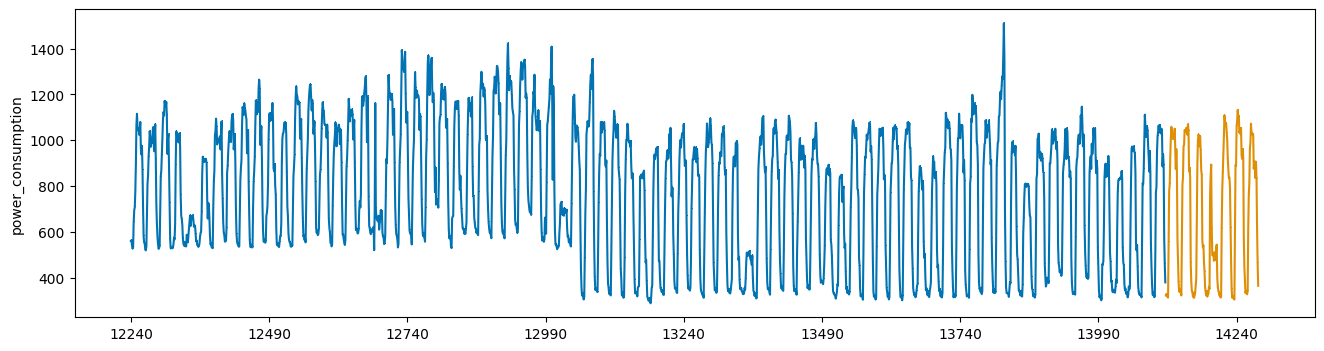

In [17]:
print('train data shape\nx:{}, y:{}'.format(x_train.shape, y_train.shape))

plot_series(y_train, y_valid, markers=[',' , ','])
plt.show()

In [18]:
def SMAPE(true, pred):
    return np.mean((np.abs(true-pred))/(np.abs(true) + np.abs(pred))) * 100

In [19]:
#### alpha를 argument로 받는 함수로 실제 objective function을 wrapping하여 alpha값을 쉽게 조정할 수 있도록 작성했습니다.
# custom objective function for forcing model not to underestimate
def weighted_mse(alpha = 1):
    def weighted_mse_fixed(label, pred):
        residual = (label - pred).astype("float")
        grad = np.where(residual>0, -2*alpha*residual, -2*residual)
        hess = np.where(residual>0, 2*alpha, 2.0)
        return grad, hess
    return weighted_mse_fixed

In [20]:
xgb_params = pd.read_csv('./parameters/hyperparameter_xgb.csv')

xgb_reg = XGBRegressor(n_estimators = 10000, eta = xgb_params.iloc[47,1], min_child_weight = xgb_params.iloc[47,2], 
                       max_depth = xgb_params.iloc[47,3], colsample_bytree = xgb_params.iloc[47,4], 
                       subsample = xgb_params.iloc[47,5], seed=0)

xgb_reg.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_valid, y_valid)],
        early_stopping_rounds=300,
       verbose=False)

C:\Users\ARIZ\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, early_stopping_rounds=None,
             enable_categorical=False, eta=0.01, eval_metric=None,
             feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
             max_leaves=None, min_child_weight=6, missing=nan,
             monotone_constraints=None, n_estimators=10000, n_jobs=None,
             num_parallel_tree=None, predictor=None, ...)

In [26]:
from sklearn.metrics import make_scorer
smape = make_scorer(SMAPE, greater_is_better = False)

In [27]:
from sklearn.model_selection import PredefinedSplit, GridSearchCV
df = pd.DataFrame(columns = ['n_estimators', 'eta', 'min_child_weight','max_depth', 'colsample_bytree', 'subsample'])
preds = np.array([])

grid = {'n_estimators' : [100], 'eta' : [0.01], 'min_child_weight' : np.arange(1, 8, 1), 
        'max_depth' : np.arange(3,9,1) , 'colsample_bytree' :np.arange(0.8, 1.0, 0.1), 
        'subsample' :np.arange(0.8, 1.0, 0.1)} # fix the n_estimators & eta(learning rate)
        
for i in tqdm(np.arange(1, 101)):
    y = train.loc[train.building_number== i, 'power_consumption']
    x = train.loc[train.building_number == i, ].drop(['power_consumption','building_number'], axis = 1)
    # y_train, y_test, x_train, x_test = temporal_train_test_split(y = y, X = x, test_size = 168)
    
    
    pds = PredefinedSplit(np.append(-np.ones(len(x)-168), np.zeros(168)))
    gcv = GridSearchCV(estimator = XGBRegressor(seed = 0, gpu_id = 1, 
                                                tree_method = 'gpu_hist', predictor= 'gpu_predictor'),
                       param_grid = grid, scoring = smape, cv = pds, refit = True, verbose = True)
    
    
    gcv.fit(x, y)
    best = gcv.best_estimator_
    params = gcv.best_params_
    print(params)
    pred = best.predict(x_test)
    building = 'building'+str(i)
    print(building + '|| SMAPE : {}'.format(SMAPE(y_test, pred)))
    preds = np.append(preds, pred)
    df = pd.concat([df, pd.DataFrame(params, index = [0])], axis = 0)
    df.to_csv('./hyperparameter_xgb.csv', index = False) # save the tuned parameters

  0%|                                                                                          | 0/100 [00:00<?, ?it/s]

Fitting 1 folds for each of 168 candidates, totalling 168 fits
[20:44:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[20:44:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[20:44:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[20:44:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[20:44:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-wi

  1%|▊                                                                               | 1/100 [01:03<1:45:17, 63.81s/it]

{'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.8}
building1|| SMAPE : 22.603024418053014
Fitting 1 folds for each of 168 candidates, totalling 168 fits
[20:45:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[20:45:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[20:45:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[20:45:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visi

  2%|█▌                                                                              | 2/100 [02:01<1:38:04, 60.05s/it]

{'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.9}
building2|| SMAPE : 42.50294103588798
Fitting 1 folds for each of 168 candidates, totalling 168 fits
[20:46:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[20:46:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[20:46:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[20:46:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visib

  3%|██▍                                                                             | 3/100 [03:04<1:39:06, 61.30s/it]

{'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 8, 'min_child_weight': 4, 'n_estimators': 100, 'subsample': 0.8}
building3|| SMAPE : 49.97694779682929
Fitting 1 folds for each of 168 candidates, totalling 168 fits
[20:47:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[20:47:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[20:47:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[20:47:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visib

  4%|███▏                                                                            | 4/100 [04:02<1:36:24, 60.25s/it]

{'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 4, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}
building4|| SMAPE : 61.76910547491617
Fitting 1 folds for each of 168 candidates, totalling 168 fits
[20:48:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[20:48:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[20:48:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[20:48:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visib

  5%|████                                                                            | 5/100 [05:09<1:39:05, 62.58s/it]

{'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 4, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.9}
building5|| SMAPE : 24.15173840039562
Fitting 1 folds for each of 168 candidates, totalling 168 fits
[20:49:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[20:49:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[20:49:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[20:49:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visib

  6%|████▊                                                                           | 6/100 [06:10<1:37:24, 62.18s/it]

{'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}
building6|| SMAPE : 37.354132028454984
Fitting 1 folds for each of 168 candidates, totalling 168 fits
[20:50:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[20:50:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[20:50:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[20:50:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visi

  7%|█████▌                                                                          | 7/100 [07:12<1:35:57, 61.91s/it]

Fitting 1 folds for each of 168 candidates, totalling 168 fits
[20:51:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[20:51:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[20:51:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[20:51:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[20:51:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-wi

  8%|██████▍                                                                         | 8/100 [07:59<1:27:53, 57.32s/it]

{'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 7, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}
building8|| SMAPE : 50.44528073217054
Fitting 1 folds for each of 168 candidates, totalling 168 fits
[20:52:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[20:52:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[20:52:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[20:52:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visib

  9%|███████▏                                                                        | 9/100 [08:59<1:28:02, 58.05s/it]

{'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 7, 'min_child_weight': 7, 'n_estimators': 100, 'subsample': 0.9}
building9|| SMAPE : 29.499676838173173
Fitting 1 folds for each of 168 candidates, totalling 168 fits
[20:53:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[20:53:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[20:53:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[20:53:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visi

 10%|███████▉                                                                       | 10/100 [09:56<1:26:54, 57.93s/it]

{'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 4, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}
building10|| SMAPE : 15.825466241257708
Fitting 1 folds for each of 168 candidates, totalling 168 fits
[20:54:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[20:54:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[20:54:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[20:54:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are vis

 11%|████████▋                                                                      | 11/100 [10:52<1:24:53, 57.23s/it]

{'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}
building11|| SMAPE : 35.83146757160037
Fitting 1 folds for each of 168 candidates, totalling 168 fits
[20:55:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[20:55:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[20:55:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[20:55:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visi

 12%|█████████▍                                                                     | 12/100 [11:52<1:24:56, 57.91s/it]

{'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.9}
building12|| SMAPE : 47.42574573671885
Fitting 1 folds for each of 168 candidates, totalling 168 fits
[20:55:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[20:56:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[20:56:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[20:56:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visi

 13%|██████████▎                                                                    | 13/100 [12:49<1:23:56, 57.89s/it]

{'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 3, 'min_child_weight': 6, 'n_estimators': 100, 'subsample': 0.8}
building13|| SMAPE : 24.534765385282963
Fitting 1 folds for each of 168 candidates, totalling 168 fits
[20:56:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[20:56:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[20:56:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[20:56:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are vis

 14%|███████████                                                                    | 14/100 [13:46<1:22:28, 57.54s/it]

{'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 4, 'min_child_weight': 7, 'n_estimators': 100, 'subsample': 0.9}
building14|| SMAPE : 37.022453620780496
Fitting 1 folds for each of 168 candidates, totalling 168 fits
[20:57:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[20:57:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[20:57:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[20:57:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are vis

 15%|███████████▊                                                                   | 15/100 [14:43<1:21:17, 57.38s/it]

{'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 5, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.8}
building15|| SMAPE : 39.1516085627008
Fitting 1 folds for each of 168 candidates, totalling 168 fits
[20:58:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[20:58:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[20:58:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[20:58:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visib

 16%|████████████▋                                                                  | 16/100 [15:45<1:22:11, 58.71s/it]

{'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 4, 'min_child_weight': 4, 'n_estimators': 100, 'subsample': 0.9}
building16|| SMAPE : 16.35959376269049
Fitting 1 folds for each of 168 candidates, totalling 168 fits
[20:59:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[20:59:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[20:59:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[20:59:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visi

 17%|█████████████▍                                                                 | 17/100 [16:48<1:23:00, 60.00s/it]

{'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 5, 'min_child_weight': 7, 'n_estimators': 100, 'subsample': 0.8}
building17|| SMAPE : 62.68258561516538
Fitting 1 folds for each of 168 candidates, totalling 168 fits
[21:00:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[21:00:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[21:00:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[21:00:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visi

 18%|██████████████▏                                                                | 18/100 [17:50<1:22:57, 60.70s/it]

{'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}
building18|| SMAPE : 48.29906468569607
Fitting 1 folds for each of 168 candidates, totalling 168 fits
[21:01:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[21:01:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[21:01:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[21:01:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visi

 19%|███████████████                                                                | 19/100 [18:49<1:21:11, 60.14s/it]

{'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 100, 'subsample': 0.9}
building19|| SMAPE : 51.18166550641521
Fitting 1 folds for each of 168 candidates, totalling 168 fits
[21:02:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[21:02:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[21:02:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[21:02:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visi

 20%|███████████████▊                                                               | 20/100 [19:41<1:16:55, 57.70s/it]

{'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 7, 'min_child_weight': 6, 'n_estimators': 100, 'subsample': 0.9}
building20|| SMAPE : 43.97638940286453
Fitting 1 folds for each of 168 candidates, totalling 168 fits
[21:03:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[21:03:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[21:03:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[21:03:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visi

 21%|████████████████▌                                                              | 21/100 [20:43<1:17:43, 59.03s/it]

{'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 5, 'min_child_weight': 2, 'n_estimators': 100, 'subsample': 0.8}
building21|| SMAPE : 36.003260243630876
Fitting 1 folds for each of 168 candidates, totalling 168 fits
[21:04:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[21:04:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[21:04:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[21:04:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are vis

 22%|█████████████████▍                                                             | 22/100 [21:43<1:17:07, 59.33s/it]

{'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 5, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.9}
building22|| SMAPE : 54.05501063111391
Fitting 1 folds for each of 168 candidates, totalling 168 fits
[21:05:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[21:05:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[21:05:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[21:05:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visi

 23%|██████████████████▏                                                            | 23/100 [22:43<1:16:11, 59.37s/it]

{'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 100, 'subsample': 0.9}
building23|| SMAPE : 53.461942072560795
Fitting 1 folds for each of 168 candidates, totalling 168 fits
[21:06:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[21:06:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[21:06:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[21:06:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are vis

 24%|██████████████████▉                                                            | 24/100 [23:44<1:16:02, 60.03s/it]

{'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 4, 'min_child_weight': 7, 'n_estimators': 100, 'subsample': 0.9}
building24|| SMAPE : 40.52191784469048
Fitting 1 folds for each of 168 candidates, totalling 168 fits
[21:07:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[21:07:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[21:07:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[21:07:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visi

 25%|███████████████████▊                                                           | 25/100 [24:39<1:13:03, 58.45s/it]

{'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 4, 'min_child_weight': 2, 'n_estimators': 100, 'subsample': 0.8}
building25|| SMAPE : 24.949998994124904
Fitting 1 folds for each of 168 candidates, totalling 168 fits
[21:08:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[21:08:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[21:08:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[21:08:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are vis

 26%|████████████████████▌                                                          | 26/100 [25:39<1:12:33, 58.83s/it]

{'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 5, 'min_child_weight': 2, 'n_estimators': 100, 'subsample': 0.9}
building26|| SMAPE : 11.475940962824675
Fitting 1 folds for each of 168 candidates, totalling 168 fits
[21:09:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[21:09:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[21:09:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[21:09:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are vis

 27%|█████████████████████▎                                                         | 27/100 [26:38<1:11:37, 58.87s/it]

{'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 4, 'min_child_weight': 7, 'n_estimators': 100, 'subsample': 0.9}
building27|| SMAPE : 61.01629662110485
Fitting 1 folds for each of 168 candidates, totalling 168 fits
[21:10:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[21:10:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[21:10:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[21:10:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visi

 28%|██████████████████████                                                         | 28/100 [27:38<1:11:12, 59.33s/it]

{'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.9}
building28|| SMAPE : 42.388800822951175
Fitting 1 folds for each of 168 candidates, totalling 168 fits
[21:11:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[21:11:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[21:11:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[21:11:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are vis

 29%|██████████████████████▉                                                        | 29/100 [28:39<1:10:42, 59.76s/it]

{'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}
building29|| SMAPE : 48.71240468717681
Fitting 1 folds for each of 168 candidates, totalling 168 fits
[21:12:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[21:12:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[21:12:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[21:12:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visi

 30%|███████████████████████▋                                                       | 30/100 [29:40<1:10:12, 60.18s/it]

{'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.8}
building30|| SMAPE : 66.08632416288674
Fitting 1 folds for each of 168 candidates, totalling 168 fits
[21:13:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[21:13:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[21:13:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[21:13:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visi

 31%|████████████████████████▍                                                      | 31/100 [30:32<1:06:18, 57.65s/it]

Fitting 1 folds for each of 168 candidates, totalling 168 fits
[21:14:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[21:14:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[21:14:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[21:14:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[21:14:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-wi

 32%|█████████████████████████▉                                                       | 32/100 [31:06<57:17, 50.55s/it]

{'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}
building32|| SMAPE : 39.105896771521806
Fitting 1 folds for each of 168 candidates, totalling 168 fits
[21:15:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[21:15:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[21:15:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[21:15:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are vis

 33%|██████████████████████████▋                                                      | 33/100 [31:50<54:28, 48.78s/it]

{'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}
building33|| SMAPE : 33.8493548905496
Fitting 1 folds for each of 168 candidates, totalling 168 fits
[21:15:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[21:15:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[21:15:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[21:15:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visib

 34%|███████████████████████████▌                                                     | 34/100 [32:37<52:57, 48.15s/it]

{'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}
building34|| SMAPE : 16.85076231455668
Fitting 1 folds for each of 168 candidates, totalling 168 fits
[21:16:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[21:16:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[21:16:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[21:16:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visi

 35%|████████████████████████████▎                                                    | 35/100 [33:18<49:49, 46.00s/it]

building35|| SMAPE : 31.08996982232548
Fitting 1 folds for each of 168 candidates, totalling 168 fits
[21:17:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[21:17:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[21:17:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[21:17:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[21:17:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0f

 36%|█████████████████████████████▏                                                   | 36/100 [33:59<47:29, 44.52s/it]

{'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}
building36|| SMAPE : 20.399475427482795
Fitting 1 folds for each of 168 candidates, totalling 168 fits
[21:18:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[21:18:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[21:18:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[21:18:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are vis

 37%|█████████████████████████████▉                                                   | 37/100 [35:20<58:15, 55.48s/it]

{'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 3, 'min_child_weight': 4, 'n_estimators': 100, 'subsample': 0.8}
building37|| SMAPE : 20.60358407005534
Fitting 1 folds for each of 168 candidates, totalling 168 fits
[21:19:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[21:19:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[21:19:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[21:19:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visi

 38%|██████████████████████████████                                                 | 38/100 [36:42<1:05:34, 63.47s/it]

{'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 7, 'min_child_weight': 2, 'n_estimators': 100, 'subsample': 0.9}
building38|| SMAPE : 46.87233115854117
Fitting 1 folds for each of 168 candidates, totalling 168 fits
[21:20:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[21:20:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[21:20:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[21:20:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visi

 39%|██████████████████████████████▊                                                | 39/100 [38:05<1:10:29, 69.34s/it]

{'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}
building39|| SMAPE : 39.744065764254636
Fitting 1 folds for each of 168 candidates, totalling 168 fits
[21:22:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[21:22:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[21:22:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[21:22:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are vis

 40%|███████████████████████████████▌                                               | 40/100 [39:29<1:13:34, 73.57s/it]

{'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.9}
building40|| SMAPE : 45.353245701619905
Fitting 1 folds for each of 168 candidates, totalling 168 fits
[21:23:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[21:23:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[21:23:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[21:23:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are vis

 41%|████████████████████████████████▍                                              | 41/100 [40:52<1:15:13, 76.50s/it]

{'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 7, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.9}
building41|| SMAPE : 20.21178017595102
Fitting 1 folds for each of 168 candidates, totalling 168 fits
[21:25:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[21:25:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[21:25:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[21:25:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visi

 42%|█████████████████████████████████▏                                             | 42/100 [42:14<1:15:23, 77.99s/it]

{'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 3, 'min_child_weight': 4, 'n_estimators': 100, 'subsample': 0.8}
building42|| SMAPE : 52.26088097428836
Fitting 1 folds for each of 168 candidates, totalling 168 fits
[21:26:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[21:26:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[21:26:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[21:26:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visi

 43%|█████████████████████████████████▉                                             | 43/100 [43:31<1:14:03, 77.95s/it]

{'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}
building43|| SMAPE : 40.690450321350305
Fitting 1 folds for each of 168 candidates, totalling 168 fits
[21:27:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[21:27:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[21:27:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[21:27:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are vis

 44%|██████████████████████████████████▊                                            | 44/100 [44:24<1:05:39, 70.35s/it]

building44|| SMAPE : 35.11856381050127
Fitting 1 folds for each of 168 candidates, totalling 168 fits
[21:28:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[21:28:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[21:28:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[21:28:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[21:28:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0f

 45%|███████████████████████████████████▌                                           | 45/100 [45:23<1:01:17, 66.87s/it]

{'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 5, 'min_child_weight': 7, 'n_estimators': 100, 'subsample': 0.9}
building45|| SMAPE : 17.462817897003877
Fitting 1 folds for each of 168 candidates, totalling 168 fits
[21:29:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[21:29:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[21:29:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[21:29:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are vis

 46%|█████████████████████████████████████▎                                           | 46/100 [46:16<56:34, 62.86s/it]

{'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 4, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}
building46|| SMAPE : 30.09244086871939
Fitting 1 folds for each of 168 candidates, totalling 168 fits
[21:30:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[21:30:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[21:30:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[21:30:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visi

 47%|██████████████████████████████████████                                           | 47/100 [47:10<53:07, 60.15s/it]

{'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 5, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.9}
building47|| SMAPE : 14.233743377880707
Fitting 1 folds for each of 168 candidates, totalling 168 fits
[21:31:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[21:31:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[21:31:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[21:31:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are vis

 48%|██████████████████████████████████████▉                                          | 48/100 [48:07<51:08, 59.02s/it]

{'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 4, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.9}
building48|| SMAPE : 37.815601402935606
Fitting 1 folds for each of 168 candidates, totalling 168 fits
[21:32:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[21:32:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[21:32:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[21:32:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are vis

 49%|███████████████████████████████████████▋                                         | 49/100 [49:14<52:18, 61.55s/it]

{'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}
building49|| SMAPE : 16.54360922208209
Fitting 1 folds for each of 168 candidates, totalling 168 fits
[21:33:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[21:33:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[21:33:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[21:33:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visi

 50%|████████████████████████████████████████▌                                        | 50/100 [50:15<51:12, 61.45s/it]

{'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}
building50|| SMAPE : 16.168237989295648
Fitting 1 folds for each of 168 candidates, totalling 168 fits
[21:34:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[21:34:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[21:34:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[21:34:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are vis

 51%|█████████████████████████████████████████▎                                       | 51/100 [51:10<48:34, 59.48s/it]

{'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 4, 'min_child_weight': 2, 'n_estimators': 100, 'subsample': 0.8}
building51|| SMAPE : 22.49001243593928
Fitting 1 folds for each of 168 candidates, totalling 168 fits
[21:35:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[21:35:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[21:35:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[21:35:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visi

 52%|██████████████████████████████████████████                                       | 52/100 [52:16<49:00, 61.26s/it]

{'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}
building52|| SMAPE : 33.979355854534646
Fitting 1 folds for each of 168 candidates, totalling 168 fits
[21:36:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[21:36:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[21:36:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[21:36:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are vis

 53%|██████████████████████████████████████████▉                                      | 53/100 [53:23<49:32, 63.24s/it]

{'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 4, 'min_child_weight': 6, 'n_estimators': 100, 'subsample': 0.9}
building53|| SMAPE : 37.03198277195319
Fitting 1 folds for each of 168 candidates, totalling 168 fits
[21:37:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[21:37:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[21:37:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[21:37:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visi

 54%|███████████████████████████████████████████▋                                     | 54/100 [54:35<50:28, 65.84s/it]

{'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 4, 'min_child_weight': 7, 'n_estimators': 100, 'subsample': 0.9}
building54|| SMAPE : 42.553957966869646
Fitting 1 folds for each of 168 candidates, totalling 168 fits
[21:38:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[21:38:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[21:38:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[21:38:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are vis

 55%|████████████████████████████████████████████▌                                    | 55/100 [55:34<47:47, 63.72s/it]

{'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 4, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}
building55|| SMAPE : 60.55622257015604
Fitting 1 folds for each of 168 candidates, totalling 168 fits
[21:39:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[21:39:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[21:39:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[21:39:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visi

 56%|█████████████████████████████████████████████▎                                   | 56/100 [56:28<44:38, 60.88s/it]

{'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}
building56|| SMAPE : 14.452625639541164
Fitting 1 folds for each of 168 candidates, totalling 168 fits
[21:40:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[21:40:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[21:40:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[21:40:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are vis

 57%|██████████████████████████████████████████████▏                                  | 57/100 [57:34<44:39, 62.31s/it]

{'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 6, 'min_child_weight': 7, 'n_estimators': 100, 'subsample': 0.8}
building57|| SMAPE : 40.490905157043535
Fitting 1 folds for each of 168 candidates, totalling 168 fits
[21:41:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[21:41:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[21:41:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[21:41:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are vis

 58%|██████████████████████████████████████████████▉                                  | 58/100 [58:16<39:24, 56.30s/it]

{'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}
building58|| SMAPE : 20.328199729674377
Fitting 1 folds for each of 168 candidates, totalling 168 fits
[21:42:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[21:42:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[21:42:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[21:42:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are vis

 59%|███████████████████████████████████████████████▊                                 | 59/100 [59:26<41:12, 60.31s/it]

{'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 3, 'min_child_weight': 6, 'n_estimators': 100, 'subsample': 0.8}
building59|| SMAPE : 47.184271863052615
Fitting 1 folds for each of 168 candidates, totalling 168 fits
[21:43:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[21:43:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[21:43:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[21:43:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are vis

 60%|███████████████████████████████████████████████▍                               | 60/100 [1:00:34<41:46, 62.65s/it]

{'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 100, 'subsample': 0.9}
building60|| SMAPE : 18.796010685947678
Fitting 1 folds for each of 168 candidates, totalling 168 fits
[21:44:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[21:44:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[21:44:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[21:44:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are vis

 61%|████████████████████████████████████████████████▏                              | 61/100 [1:01:40<41:25, 63.72s/it]

{'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.8}
building61|| SMAPE : 19.608646191814646
Fitting 1 folds for each of 168 candidates, totalling 168 fits
[21:45:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[21:45:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[21:45:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[21:45:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are vis

 62%|████████████████████████████████████████████████▉                              | 62/100 [1:02:48<41:04, 64.85s/it]

{'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 4, 'min_child_weight': 6, 'n_estimators': 100, 'subsample': 0.9}
building62|| SMAPE : 55.81255075306322
Fitting 1 folds for each of 168 candidates, totalling 168 fits
[21:46:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[21:46:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[21:46:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[21:46:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visi

 63%|█████████████████████████████████████████████████▊                             | 63/100 [1:03:55<40:23, 65.51s/it]

{'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 6, 'min_child_weight': 7, 'n_estimators': 100, 'subsample': 0.9}
building63|| SMAPE : 68.4126160493806
Fitting 1 folds for each of 168 candidates, totalling 168 fits
[21:48:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[21:48:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[21:48:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[21:48:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visib

 64%|██████████████████████████████████████████████████▌                            | 64/100 [1:04:53<37:54, 63.18s/it]

{'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}
building64|| SMAPE : 52.71848353490892
Fitting 1 folds for each of 168 candidates, totalling 168 fits
[21:49:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[21:49:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[21:49:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[21:49:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visi

 65%|███████████████████████████████████████████████████▎                           | 65/100 [1:06:01<37:45, 64.73s/it]

{'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 5, 'min_child_weight': 2, 'n_estimators': 100, 'subsample': 0.9}
building65|| SMAPE : 73.51278950293289
Fitting 1 folds for each of 168 candidates, totalling 168 fits
[21:50:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[21:50:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[21:50:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[21:50:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visi

 66%|████████████████████████████████████████████████████▏                          | 66/100 [1:07:06<36:43, 64.80s/it]

{'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}
building66|| SMAPE : 81.83167283449477
Fitting 1 folds for each of 168 candidates, totalling 168 fits
[21:51:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[21:51:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[21:51:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[21:51:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visi

 67%|████████████████████████████████████████████████████▉                          | 67/100 [1:08:14<36:12, 65.83s/it]

{'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 100, 'subsample': 0.9}
building67|| SMAPE : 51.42318349763079
Fitting 1 folds for each of 168 candidates, totalling 168 fits
[21:52:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[21:52:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[21:52:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[21:52:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visi

 68%|█████████████████████████████████████████████████████▋                         | 68/100 [1:09:15<34:21, 64.43s/it]

{'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}
building68|| SMAPE : 34.71201923404569
Fitting 1 folds for each of 168 candidates, totalling 168 fits
[21:53:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[21:53:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[21:53:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[21:53:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visi

 69%|██████████████████████████████████████████████████████▌                        | 69/100 [1:10:14<32:20, 62.61s/it]

{'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 5, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.8}
building69|| SMAPE : 9.964491355061144
Fitting 1 folds for each of 168 candidates, totalling 168 fits
[21:54:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[21:54:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[21:54:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[21:54:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visi

 70%|███████████████████████████████████████████████████████▎                       | 70/100 [1:11:06<29:51, 59.70s/it]

Fitting 1 folds for each of 168 candidates, totalling 168 fits
[21:55:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[21:55:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[21:55:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[21:55:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[21:55:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-wi

 71%|████████████████████████████████████████████████████████                       | 71/100 [1:12:00<27:53, 57.71s/it]

{'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 4, 'min_child_weight': 6, 'n_estimators': 100, 'subsample': 0.9}
building71|| SMAPE : 30.667356929550042
Fitting 1 folds for each of 168 candidates, totalling 168 fits
[21:56:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[21:56:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[21:56:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[21:56:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are vis

 72%|████████████████████████████████████████████████████████▉                      | 72/100 [1:12:56<26:43, 57.25s/it]

{'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 100, 'subsample': 0.8}
building72|| SMAPE : 51.204589662554326
Fitting 1 folds for each of 168 candidates, totalling 168 fits
[21:57:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[21:57:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[21:57:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[21:57:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are vis

 73%|█████████████████████████████████████████████████████████▋                     | 73/100 [1:13:48<25:08, 55.88s/it]

{'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 5, 'min_child_weight': 7, 'n_estimators': 100, 'subsample': 0.9}
building73|| SMAPE : 13.811460627707673
Fitting 1 folds for each of 168 candidates, totalling 168 fits
[21:57:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[21:57:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[21:57:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[21:57:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are vis

 74%|██████████████████████████████████████████████████████████▍                    | 74/100 [1:14:52<25:10, 58.08s/it]

{'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 4, 'min_child_weight': 6, 'n_estimators': 100, 'subsample': 0.9}
building74|| SMAPE : 11.393906617414096
Fitting 1 folds for each of 168 candidates, totalling 168 fits
[21:59:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[21:59:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[21:59:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[21:59:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are vis

 75%|███████████████████████████████████████████████████████████▎                   | 75/100 [1:16:09<26:38, 63.96s/it]

{'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 3, 'min_child_weight': 7, 'n_estimators': 100, 'subsample': 0.8}
building75|| SMAPE : 48.54199189347499
Fitting 1 folds for each of 168 candidates, totalling 168 fits
[22:00:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[22:00:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[22:00:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[22:00:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visi

 76%|████████████████████████████████████████████████████████████                   | 76/100 [1:17:42<29:01, 72.57s/it]

{'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 7, 'min_child_weight': 2, 'n_estimators': 100, 'subsample': 0.9}
building76|| SMAPE : 53.82113673060908
Fitting 1 folds for each of 168 candidates, totalling 168 fits
[22:01:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[22:01:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[22:01:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[22:01:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visi

 77%|████████████████████████████████████████████████████████████▊                  | 77/100 [1:19:18<30:31, 79.62s/it]

{'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 5, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.9}
building77|| SMAPE : 48.0475227013155
Fitting 1 folds for each of 168 candidates, totalling 168 fits
[22:03:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[22:03:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[22:03:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[22:03:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visib

 78%|█████████████████████████████████████████████████████████████▌                 | 78/100 [1:20:58<31:24, 85.67s/it]

{'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 6, 'min_child_weight': 7, 'n_estimators': 100, 'subsample': 0.8}
building78|| SMAPE : 45.19777717558066
Fitting 1 folds for each of 168 candidates, totalling 168 fits
[22:05:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[22:05:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[22:05:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[22:05:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visi

 79%|██████████████████████████████████████████████████████████████▍                | 79/100 [1:22:36<31:17, 89.38s/it]

{'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}
building79|| SMAPE : 18.779297069709237
Fitting 1 folds for each of 168 candidates, totalling 168 fits
[22:06:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[22:06:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[22:06:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[22:06:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are vis

 80%|███████████████████████████████████████████████████████████████▏               | 80/100 [1:24:16<30:50, 92.53s/it]

{'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 8, 'min_child_weight': 4, 'n_estimators': 100, 'subsample': 0.9}
building80|| SMAPE : 29.492391427744526
Fitting 1 folds for each of 168 candidates, totalling 168 fits
[22:08:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[22:08:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[22:08:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[22:08:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are vis

 81%|███████████████████████████████████████████████████████████████▉               | 81/100 [1:25:47<29:11, 92.17s/it]

{'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.8}
building81|| SMAPE : 52.401057569703504
Fitting 1 folds for each of 168 candidates, totalling 168 fits
[22:09:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[22:09:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[22:09:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[22:09:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are vis

 82%|████████████████████████████████████████████████████████████████▊              | 82/100 [1:27:22<27:51, 92.86s/it]

{'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}
building82|| SMAPE : 30.50264263111322
Fitting 1 folds for each of 168 candidates, totalling 168 fits
[22:11:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[22:11:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[22:11:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[22:11:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visi

 83%|█████████████████████████████████████████████████████████████████▌             | 83/100 [1:29:01<26:54, 94.95s/it]

{'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.9}
building83|| SMAPE : 51.16767878995812
Fitting 1 folds for each of 168 candidates, totalling 168 fits
[22:13:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[22:13:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[22:13:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[22:13:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visi

 84%|██████████████████████████████████████████████████████████████████▎            | 84/100 [1:30:40<25:35, 95.98s/it]

{'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 6, 'min_child_weight': 2, 'n_estimators': 100, 'subsample': 0.9}
building84|| SMAPE : 42.91911492908805
Fitting 1 folds for each of 168 candidates, totalling 168 fits
[22:14:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[22:14:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[22:14:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[22:14:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visi

 85%|███████████████████████████████████████████████████████████████████▏           | 85/100 [1:32:09<23:28, 93.91s/it]

{'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 5, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.9}
building85|| SMAPE : 28.833820050956625
Fitting 1 folds for each of 168 candidates, totalling 168 fits
[22:16:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[22:16:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[22:16:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[22:16:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are vis

 86%|███████████████████████████████████████████████████████████████████▉           | 86/100 [1:33:47<22:12, 95.19s/it]

{'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 100, 'subsample': 0.9}
building86|| SMAPE : 57.73253032367654
Fitting 1 folds for each of 168 candidates, totalling 168 fits
[22:17:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[22:17:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[22:17:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[22:17:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visi

 87%|████████████████████████████████████████████████████████████████████▋          | 87/100 [1:35:21<20:32, 94.82s/it]

{'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}
building87|| SMAPE : 50.41695331727789
Fitting 1 folds for each of 168 candidates, totalling 168 fits
[22:19:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[22:19:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[22:19:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[22:19:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visi

 88%|█████████████████████████████████████████████████████████████████████▌         | 88/100 [1:36:59<19:08, 95.72s/it]

{'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 4, 'min_child_weight': 4, 'n_estimators': 100, 'subsample': 0.9}
building88|| SMAPE : 57.867372350966065
Fitting 1 folds for each of 168 candidates, totalling 168 fits
[22:21:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[22:21:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[22:21:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[22:21:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are vis

 89%|██████████████████████████████████████████████████████████████████████▎        | 89/100 [1:38:39<17:46, 96.93s/it]

{'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 4, 'min_child_weight': 4, 'n_estimators': 100, 'subsample': 0.9}
building89|| SMAPE : 51.67019434418984
Fitting 1 folds for each of 168 candidates, totalling 168 fits
[22:22:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[22:22:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[22:22:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[22:22:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visi

 90%|███████████████████████████████████████████████████████████████████████        | 90/100 [1:40:21<16:25, 98.60s/it]

{'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}
building90|| SMAPE : 54.6918220704821
Fitting 1 folds for each of 168 candidates, totalling 168 fits
[22:24:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[22:24:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[22:24:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[22:24:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visib

 91%|███████████████████████████████████████████████████████████████████████▉       | 91/100 [1:42:00<14:47, 98.64s/it]

{'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.8}
building91|| SMAPE : 56.400484489509715
Fitting 1 folds for each of 168 candidates, totalling 168 fits
[22:26:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[22:26:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[22:26:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[22:26:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are vis

 92%|████████████████████████████████████████████████████████████████████████▋      | 92/100 [1:43:39<13:11, 98.88s/it]

{'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 6, 'min_child_weight': 2, 'n_estimators': 100, 'subsample': 0.9}
building92|| SMAPE : 54.883089420031105
Fitting 1 folds for each of 168 candidates, totalling 168 fits
[22:27:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[22:27:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[22:27:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[22:27:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are vis

 93%|█████████████████████████████████████████████████████████████████████████▍     | 93/100 [1:45:12<11:20, 97.15s/it]

{'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 7, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}
building93|| SMAPE : 56.8016650383635
Fitting 1 folds for each of 168 candidates, totalling 168 fits
[22:29:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[22:29:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[22:29:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[22:29:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visib

 94%|██████████████████████████████████████████████████████████████████████████▎    | 94/100 [1:46:47<09:38, 96.49s/it]

{'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 8, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.9}
building94|| SMAPE : 24.971291101849122
Fitting 1 folds for each of 168 candidates, totalling 168 fits
[22:30:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[22:30:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[22:30:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[22:30:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are vis

 95%|███████████████████████████████████████████████████████████████████████████    | 95/100 [1:48:28<08:08, 97.65s/it]

{'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 4, 'min_child_weight': 7, 'n_estimators': 100, 'subsample': 0.8}
building95|| SMAPE : 55.02341561036511
Fitting 1 folds for each of 168 candidates, totalling 168 fits
[22:32:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[22:32:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[22:32:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[22:32:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visi

 96%|███████████████████████████████████████████████████████████████████████████▊   | 96/100 [1:50:01<06:25, 96.40s/it]

{'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}
building96|| SMAPE : 18.40515146745701
Fitting 1 folds for each of 168 candidates, totalling 168 fits
[22:34:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[22:34:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[22:34:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[22:34:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visi

 97%|████████████████████████████████████████████████████████████████████████████▋  | 97/100 [1:51:14<04:28, 89.43s/it]

{'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 6, 'min_child_weight': 4, 'n_estimators': 100, 'subsample': 0.9}
building97|| SMAPE : 54.690232761429925
Fitting 1 folds for each of 168 candidates, totalling 168 fits
[22:35:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[22:35:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[22:35:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[22:35:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are vis

 98%|█████████████████████████████████████████████████████████████████████████████▍ | 98/100 [1:52:22<02:45, 82.91s/it]

{'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 5, 'min_child_weight': 2, 'n_estimators': 100, 'subsample': 0.9}
building98|| SMAPE : 57.13315424270954
Fitting 1 folds for each of 168 candidates, totalling 168 fits
[22:36:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[22:36:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[22:36:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[22:36:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visi

 99%|██████████████████████████████████████████████████████████████████████████████▏| 99/100 [1:53:21<01:15, 75.60s/it]

{'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 4, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.9}
building99|| SMAPE : 55.013630178120856
Fitting 1 folds for each of 168 candidates, totalling 168 fits
[22:37:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[22:37:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[22:37:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are visible, setting `gpu_id` to 0
[22:37:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:347: Only 1 GPUs are vis

100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [1:54:20<00:00, 68.60s/it]

{'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 4, 'min_child_weight': 2, 'n_estimators': 100, 'subsample': 0.9}
building100|| SMAPE : 66.81082369236351


best iterations: 351
SMAPE : 4.639276464426937


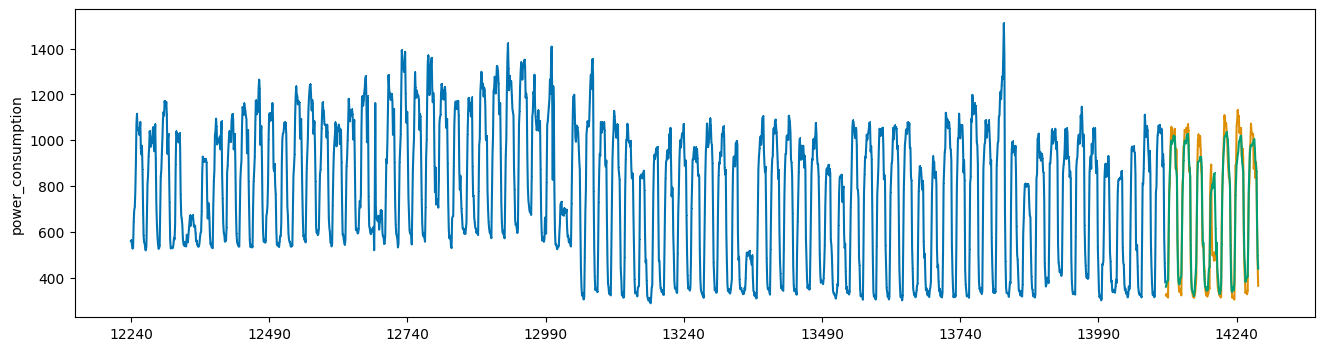

In [24]:
## 주황색이 실제 전력소비량, 초록색이 예측값입니다.
pred = xgb_reg.predict(x_valid)
pred = pd.Series(pred)
pred.index = np.arange(y_valid.index[0], y_valid.index[-1]+1)
plot_series(y_train, y_valid, pd.Series(pred), markers=[',' , ',', ','])

print('best iterations: {}'.format(xgb_reg.best_iteration))
print('SMAPE : {}'.format(SMAPE(y_valid, pred)))

In [25]:
xgb_reg = XGBRegressor(n_estimators = 10000, eta = xgb_params.iloc[47,1], min_child_weight = xgb_params.iloc[47,2], 
                       max_depth = xgb_params.iloc[47,3], colsample_bytree = xgb_params.iloc[47,4], 
                       subsample = xgb_params.iloc[47,5], seed=0)

xgb_reg.set_params(**{'objective':weighted_mse(100)})

xgb_reg.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_valid, y_valid)],
        early_stopping_rounds=300,
       verbose=False)

C:\Users\ARIZ\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, early_stopping_rounds=None,
             enable_categorical=False, eta=0.01, eval_metric=None,
             feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
             max_leaves=None, min_child_weight=6, missing=nan,
             monotone_constraints=None, n_estimators=10000, n_jobs=None,
             num_parallel_tree=None,
             objective=<function weighted_mse.<locals>.weighted_mse_fixed at 0x000001D126F92520>, ...)

## model tunning

In [32]:
xgb_params

,n_estimators,eta,min_child_weight,max_depth,colsample_bytree,subsample
0,100,0.01,4,5,0.8,0.8
1,100,0.01,6,3,0.8,0.9
2,100,0.01,6,7,0.9,0.9
3,100,0.01,3,7,0.8,0.9
4,100,0.01,2,6,0.9,0.9
...,...,...,...,...,...,...
82,100,0.01,6,4,0.8,0.9
83,100,0.01,2,4,0.8,0.8
84,100,0.01,2,4,0.8,0.9
85,100,0.01,4,6,0.8,0.9


In [28]:
xgb_params = pd.read_csv('./hyperparameter_xgb.csv')

In [ ]:
scores = []   # smape 값을 저장할 list
best_it = []  # best interation을 저장할 list
for i in tqdm(range(100)):
    y = train.loc[train.building_number== i+1, 'power_consumption']
    x = train.loc[train.building_number == i+1, ].drop(['power_consumption','building_number'], axis = 1)
    y_train, y_valid, x_train, x_valid = temporal_train_test_split(y = y, X = x, test_size = 168)
    
    xgb_reg = XGBRegressor(n_estimators = 10000, eta = 0.01, min_child_weight = xgb_params.iloc[i, 2],
                           max_depth = xgb_params.iloc[i, 3], colsample_bytree = xgb_params.iloc[i, 4], 
                           subsample = xgb_params.iloc[i, 5], seed=0)
    xgb_reg.set_params(**{'objective':weighted_mse(100)}) # alpha = 100으로 고정
    
    xgb_reg.fit(x_train, y_train, eval_set=[(x_train, y_train), 
                                            (x_valid, y_valid)], early_stopping_rounds=300, verbose=False)
    y_pred = xgb_reg.predict(x_valid)
    pred = pd.Series(y_pred)   
    
    sm = SMAPE(y_valid, y_pred)
    scores.append(sm)
    best_it.append(xgb_reg.best_iteration) ## 실제 best iteration은 이 값에 +1 해주어야 함.

  0%|                                                                                          | 0/100 [00:00<?, ?it/s]C:\Users\ARIZ\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
  1%|▊                                                                                 | 1/100 [00:03<05:31,  3.34s/it]C:\Users\ARIZ\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
  2%|█▋                                                                                | 2/100 [00:05<04:32,  2.78s/it]C:\Users\ARIZ\AppData\Local\Programs\Python\Python311\Lib\sit

# test inference

In [ ]:
test['date_time'] = pd.to_datetime(test['date_time'], format='%Y%m%d %H')

# date time feature 생성
test['hour'] = test['date_time'].dt.hour
test['day'] = test['date_time'].dt.weekday
test['month'] = test['date_time'].dt.month
#train['week'] = train['date_time'].dt.weekofyear

# 공휴일 변수 추가 
test['holiday'] = test['day'] .apply(lambda x : 0 if x<5 else 1)


# hour
test['sin_time'] = np.sin(2*np.pi*test.hour/24)
test['cos_time'] = np.cos(2*np.pi*test.hour/24)


def CDH(xs):
    ys = []
    for i in range(len(xs)):
        if i < 11:
            ys.append(np.sum(xs[:(i+1)]-26))
        else:
            ys.append(np.sum(xs[(i-11):(i+1)]-26))
    return np.array(ys)

cdhs = np.array([])
for num in range(1,101):
    temp = test[test['building_number'] == num]
    cdh = CDH(temp['temperature'].values)
    cdhs = np.concatenate([cdhs, cdh])
test['CDH'] = cdhs

test['solar_power_capacity'] = test['solar_power_capacity'].apply(lambda x : 0 if x=='-' else float(x))
test['ess_capacity'] = test['ess_capacity'].apply(lambda x : 0 if x=='-' else float(x))
test['pcs_capacity'] = test['pcs_capacity'].apply(lambda x : 0 if x=='-' else float(x))
test['building_type'] = test['building_type'].apply(lambda x :int(x))

test = test.fillna(0)
test.drop(['date_time','hour'],axis = 1,inplace = True)

In [ ]:
xgb_params['best_it'] = best_it

In [ ]:
preds = np.array([]) 
for i in tqdm(range(100)):
    
    pred_df = pd.DataFrame()   # 시드별 예측값을 담을 data frame
    
    for seed in [0,1,2,3,4,5]: # 각 시드별 예측
        y_train = train.loc[train.building_number== i+1, 'power_consumption']
        x_train = train.loc[train.building_number == i+1, ].drop(['power_consumption','building_number'], axis = 1)
        x_test = test.loc[test.building_number == i+1, ].drop(['building_number'], axis = 1)
        x_test = x_test[x_train.columns]
        
        xgb = XGBRegressor(seed = seed, n_estimators = best_it[i], eta = 0.01, 
                           min_child_weight = xgb_params.iloc[i, 2], max_depth = xgb_params.iloc[i, 3], 
                           colsample_bytree=xgb_params.iloc[i, 4], subsample=xgb_params.iloc[i, 5])
    
        
        xgb.fit(x_train, y_train)
        y_pred = xgb.predict(x_test)
        pred_df.loc[:,seed] = y_pred   # 각 시드별 예측 담기
        
    pred = pred_df.mean(axis=1)        # (i+1)번째 건물의 예측 =  (i+1)번째 건물의 각 시드별 예측 평균값
    preds = np.append(preds, pred)   

In [ ]:
x_test

In [ ]:
submission = pd.read_csv('./data/sample_submission.csv')
submission['answer'] = preds

In [ ]:
submission.to_csv('./submission_xgb_tune.csv', index = False)

In [90]:
submission = pd.read_csv('data/sample_submission.csv')
submission

,num_date_time,answer
0,1_20220825 00,0
1,1_20220825 01,0
2,1_20220825 02,0
3,1_20220825 03,0
4,1_20220825 04,0
...,...,...
16795,100_20220831 19,0
16796,100_20220831 20,0
16797,100_20220831 21,0
16798,100_20220831 22,0


In [91]:
submission['answer'] = preds
submission

,num_date_time,answer
0,1_20220825 00,2005.698608
1,1_20220825 01,1983.620605
2,1_20220825 02,1812.153442
3,1_20220825 03,1746.236938
4,1_20220825 04,1755.779907
...,...,...
16795,100_20220831 19,864.849426
16796,100_20220831 20,770.695740
16797,100_20220831 21,716.914856
16798,100_20220831 22,638.015930
